In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import Image

## Exposure fusion algorithm by Mertens et al. 

This notebook presents an implementation of Mertens' image fusion algorithm in a python code. This code is written based on the Merten's paper, and the results are compared to those of Mertens' MATLAB code.  

As shown below, differently exposed images look very different in terms of brightness as well as details on the images. As the image went underexposed, the image becomes dark and loss details on the darker region, whereas the image becomes too bright and also loss details on the brighter region as become overexposed. To capture all details on the image, they needs to be improved by combining them. 

The exposure fusion algorithm performs the fusion to obtain a good quality image, which will look both bright and dark part clearly. 

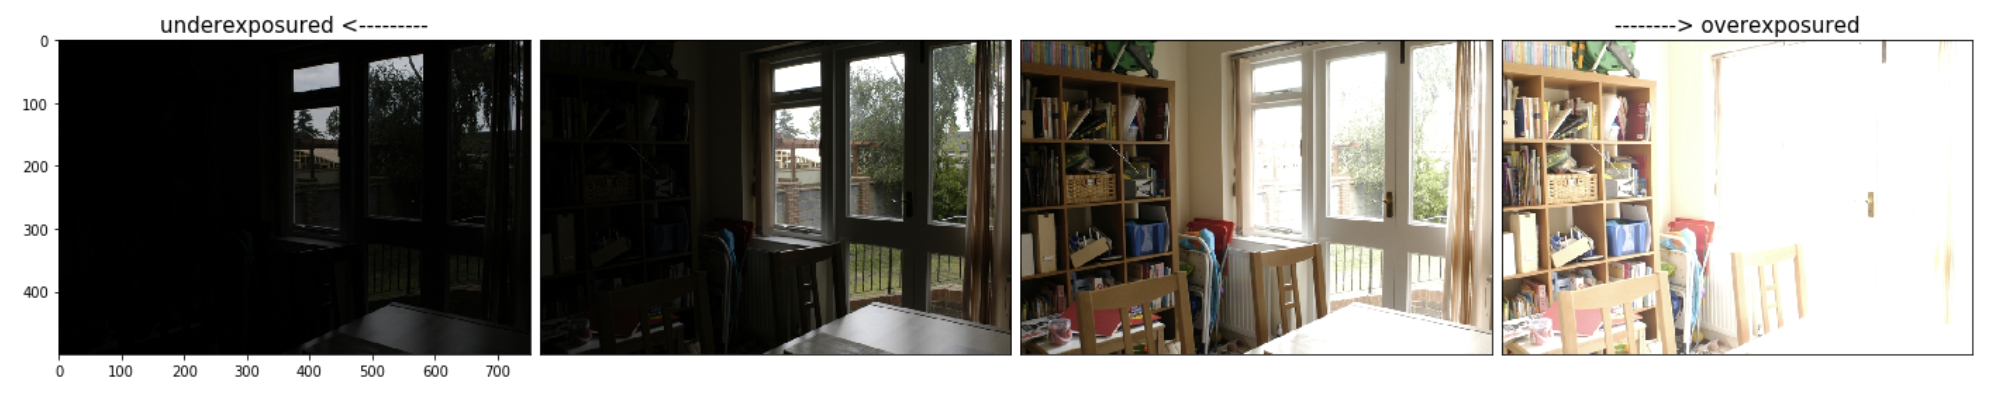

In [2]:
display(Image(filename='/Users/gimoonnam/myGit/notRepos/ImageProcessing/images/houses.png', width=1000))


This algorithm carris out multiresolution blending by constructing Gaussian and Laplacian image pyramids. The image blending using such pyramids is a powerful method, and yields a high quality image. 

Besides, the Mertens' algorithm does not require a conversion to an HDR image, which is thus proposed as an effective method for an image fusion, as a counterpart of others involving the conversion. The demonstration of HDR's fusion will be studied soon though.  



### Quality measures

**Contrast ($C$)**

Application of a Laplacian filter to the grayscale version of images, and take the absolute value of the filtered image. The contrast map captures details on images such as edges and texture. The resultant map is indicated as $C$. 

**Saturation ($S$)**

The Saturation measures the degree of the exposure. A longer exposed image contains desaturated colors, which will eventually be clipped off. It is desirable to have saturated colors to make vivid images. Here, the saturation is measured as a STD of R, G, and B at each pixel.


**Well-exposedness ($E$)**

The raw intensities within a channel reveals how well a pixel is exposed, which is used to make sure that the intensities of all pixels are well ranged between 0 and 1, resepctively, under- and over-exposed. The well-exposedness is evaluated by a Gaussian filter with a mean of 0.5, and this filter applies to each channel individually, each of which will be multiplied to yiled the meausre $E$. 



The weight map with the above three measures are given as a power function

$$ 
W_{ij,k} = \left(C_{ij,k}\right)^{\omega_C}\times \left(S_{ij,k}\right)^{\omega_S} \times \left(E_{ij,k}\right)^{\omega_E}                                 
\tag{1}
$$

where $k$ indicates an index of image in given image stack, and $i,j$ are pixel's indices. The relative contributions of each measure to the weight is controlled by the exponents of $\Omega$, varying between 0 and 1.


## Fusion

Once the weight maps are constructed for each images, the map needs to be normalized to obtain a consistent result as following,

$$
\hat{W}_{ij,k} = \frac{W_{ij,k}}{\left[\sum_{k^{\prime}}^{N} W_{ij,k^{\prime}} \right]}
\tag{2}
$$

The resultant fusion image can then be obtained via a weighted blending of image stack. But it was turned out that the simple fusion produced undesired disturbing seams and halos on resulting images. 

To get around this problem, the authors employed a multiple resolutions using pyramidal images decomposition. 

Before blending images, the Laplacian pyramid is generated as a weighted average of Laplacian decompositions for original images and Gaussian pyramid of the weight map. 

$$
\mathbf{L}[R]_{ij}^l = \sum_{k=1}^{N}\mathbf{G}[{\hat W}]_{ij,k}^l \mathbf{L}[I]_{ij,k}^l
\tag{3}
$$

Then the final result is obtained by collapsing the Laplacian pyramid up to the original image size. 

$$
R_{ij} = \sum_{k=1}^N \mathbf{L}[R]_{ij} I_{ij,k}
\tag{4}
$$




In [3]:
class exposureFusion:
    def __init__(self, weightParam, nlev):
        
        # read images and save them as a stack 
        path = os.getcwd() + "/house/"    

        filenames = ["A.jpg","B.jpg","C.jpg","D.jpg"]    
        self.images = []
        
        for filename in filenames:
            im = cv2.imread(path+filename).astype(np.float32)/255.0
            self.images.append(im)
    
        self.N = len(self.images) # the number of images 
        self.width  = len(self.images[0]) 
        self.height = len(self.images[0][0])
        self.weightParam = weightParam 
        self.nlev = nlev # number of levels in image pyramids 
    

    def showOriginalImages(self,figureSize):
        w_grid = self.width*(self.N+1)
        fig = plt.figure(constrained_layout=False,figsize=figureSize)
        gs = gridspec.GridSpec(self.height,w_grid,figure=fig)
        s1=0

        ax = fig.add_subplot(gs[:,0:self.width],aspect='equal')
        ax.imshow(cv2.cvtColor(self.images[0],cv2.COLOR_BGR2RGB))            
 

        offset = 10
        for i in range(1,self.N):
            ax = fig.add_subplot(gs[:,self.width*i+offset*i:self.width*(i+1)+offset*i],aspect='equal')
            ax.imshow(cv2.cvtColor(self.images[i],cv2.COLOR_BGR2RGB))            
            ax.set_xticks([])
            ax.set_yticks([])
        
            if i==self.N-3:
                ax.set_title('Original images',fontsize=20)
                
    def display_pyramid(self,pyrc,isColorImage):
        r = len(pyrc[0])
        c = len(pyrc[0][0])
        
        if isColorImage:
            Rpyr = np.ones((r,2*c,3),dtype=np.float32)
        else:
            Rpyr = np.ones((r,2*c),dtype=np.float32)
    
        offset = 0
        for l in range(self.nlev):
            r, c = len(pyrc[l]),len(pyrc[l][0])
            if isColorImage:
                Rpyr[0:r, offset:offset+c,:] = pyrc[l]
            else:
                Rpyr[0:r, offset:offset+c] = pyrc[l]            
            offset += c
        
        fig = plt.figure(constrained_layout=False,figsize=(20,20))
        plt.imshow(Rpyr)

            
    def getContrastWeight(self): return self.contrast_para
    def getSaturationWeight(self): return self.sat_para
    def getExposurednessWeight(self): return self.wexp_para
    
    def ConstructWeightMap(self):
        self.contrast_para, self.sat_para, self.wexp_para = self.weightParam 
        
        self.W = np.ones((self.N, self.width,self.height),dtype=np.float32)
        
        if self.contrast_para > 0:
            self.W = np.power(np.multiply(self.W, self.contrast()),self.contrast_para)
            
        if self.sat_para > 0:
            self.W = np.power(np.multiply(self.W, self.saturation()),self.sat_para)
        
        if self.wexp_para > 0:
            self.W = np.power(np.multiply(self.W, self.well_exposedness()),self.wexp_para)    

        # normalize weight map, whose size will be (width,height,n_images)
        W_sum = self.W.sum(axis=0)
        self.W = np.divide(self.W, W_sum+1e-12)
        np.seterr(divide='ignore', invalid='ignore')        
    
    
    def contrast(self):
        C = np.zeros((self.N, self.width,self.height),dtype=np.float32)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]],dtype = np.float32)
        for i in range(self.N):
            mono = cv2.cvtColor(self.images[i], cv2.COLOR_RGB2GRAY)
            C[i] = abs(cv2.filter2D(mono,-1,kernel))
        return C
        
    def saturation(self):
        S = np.zeros((self.N,self.width,self.height),dtype=np.float32)
        for i in range(self.N):
            # saturation is computed as the standard deviation of the color channels
            B, G, R = cv2.split(self.images[i])
            S[i]=np.std([B,G,R],axis=0)

        return S

    def well_exposedness(self):
        sig = .2;
        sig2 = sig*sig
        E = np.zeros((self.N,self.width,self.height),dtype=np.float32)
        for i in range(self.N):
            b, g, r = cv2.split(self.images[i])
            R = np.exp(-0.5*np.power(r-0.5,2)/sig2)
            G = np.exp(-0.5*np.power(g-0.5,2)/sig2)        
            B = np.exp(-0.5*np.power(b-0.5,2)/sig2)                
            E[i] = np.multiply(R,np.multiply(G,B))
        return E

    def gaussianPyrWeightMap(self,W_k):
        WC = W_k.copy()
        pyrW = [WC]
        for i in range(1,self.nlev):
            WC = cv2.pyrDown(cv2.GaussianBlur(WC, (3, 3), 0) )
            pyrW.append(WC)
            
        return pyrW
    
    def laplacianPyrImage(self,I): 
        pyrL =[]
    
        J = I.copy()
        for i in range(0,self.nlev-1):
        
            src = cv2.GaussianBlur(J, (3, 3), 0)            
            I = cv2.pyrDown(src)
            GAU  = cv2.pyrUp(I)
            temp = cv2.resize(GAU,(J.shape[:2][1],J.shape[:2][0]))
            L = cv2.subtract(J,temp)
        
            pyrL.append(L)
            J = I.copy()
            
        pyrL.append(I)
        return pyrL
            
    def multiresolution_blending(self):
        # this function is to get the Laplacian pyramid eq.3 
        
        # initialize image pyramid for reconstruction 
        w,h = self.width, self.height
        self.pyr = [np.zeros((w,h,3),dtype=np.float32)]
        for _ in range(self.nlev):
            w = int(np.ceil(w/2))
            h = int(np.ceil(h/2))    
            self.pyr.append(np.zeros((w,h,3),dtype=np.float32))
    
        # construct the image pyramid 
        for i in range(self.N):
            pyrW = self.gaussianPyrWeightMap(self.W[i])
            pyrI = self.laplacianPyrImage(self.images[i])

            for l in range(self.nlev):
                r,c = len(pyrW[l]), len(pyrW[l][0])
                b = np.zeros((r,c,3),dtype=np.float32)

                b[:,:,0]= pyrW[l]
                b[:,:,1]= pyrW[l]
                b[:,:,2]= pyrW[l]
                
                self.pyr[l] += np.multiply(b,pyrI[l])
        
    def process(self):
        # proceed multiresolution blending with Laplacian pyramid by eq.4 
        self.ConstructWeightMap()
        self.multiresolution_blending()                
        self.R = self.pyr[self.nlev-1].copy()
        
        for l in range(self.nlev-2,-1,-1):
            GE = cv2.pyrUp(self.R)
            temp = cv2.resize(GE,(self.pyr[l].shape[:2][1],self.pyr[l].shape[:2][0]))
            self.R = self.pyr[l] + temp
        
    def displayOutputImage(self,figureSize,title):
        fig = plt.figure(constrained_layout=False,figsize=figureSize)
        ax = fig.add_subplot(111)
        ax.set_title(title, fontdict={'fontsize': 20, 'fontweight': 'medium'})
        plt.imshow(cv2.cvtColor(self.R,cv2.COLOR_BGR2RGB))            

        
        

In [4]:
# only by contrast weight map 
weightParam = np.array([1,0,0],dtype=np.float32)
mergeMertens_con= exposureFusion(weightParam,nlev=8)
mergeMertens_con.process()

# only by saturation weight map 
weightParam = np.array([0,1,0],dtype=np.float32)
mergeMertens_sat= exposureFusion(weightParam,nlev=8)
mergeMertens_sat.process()

# only by exposedness weight map 
weightParam = np.array([0,0,1],dtype=np.float32)
mergeMertens_exp= exposureFusion(weightParam,nlev=8)
mergeMertens_exp.process()

# by all of three quality measures 
weightParam = np.array([1,1,1],dtype=np.float32)
mergeMertens_all= exposureFusion(weightParam,nlev=8)
mergeMertens_all.process()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


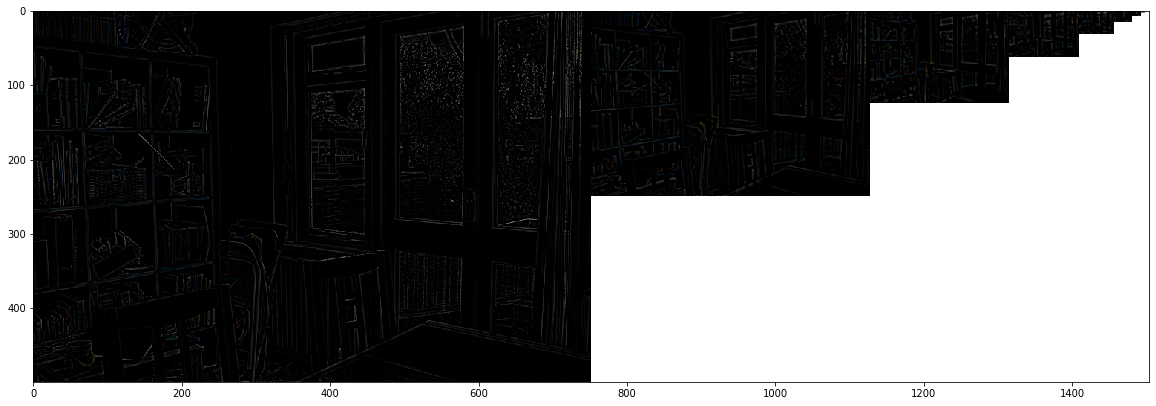

In [5]:
# check the Laplacian pyramid eq.3 
mergeMertens_all.display_pyramid(mergeMertens_all.pyr,True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


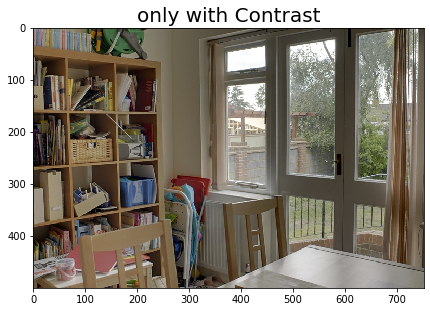

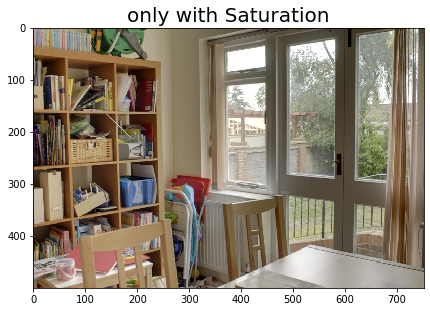

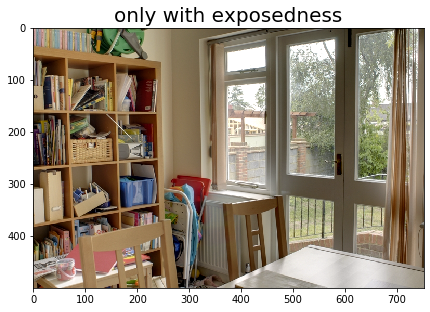

In [6]:
# plot results with different quality measures 

# weight exponents = (contrast, saturation, well-exposedness)

#(1,0,0)
mergeMertens_con.displayOutputImage(figureSize=(7,7),title='only with Contrast')

#(0,1,0)
mergeMertens_sat.displayOutputImage(figureSize=(7,7),title='only with Saturation')

#(0,0,1)
mergeMertens_exp.displayOutputImage(figureSize=(7,7),title='only with exposedness')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


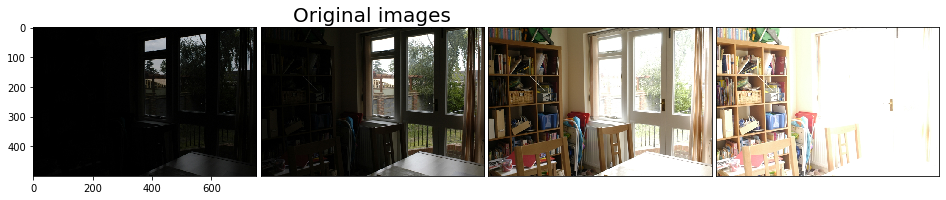

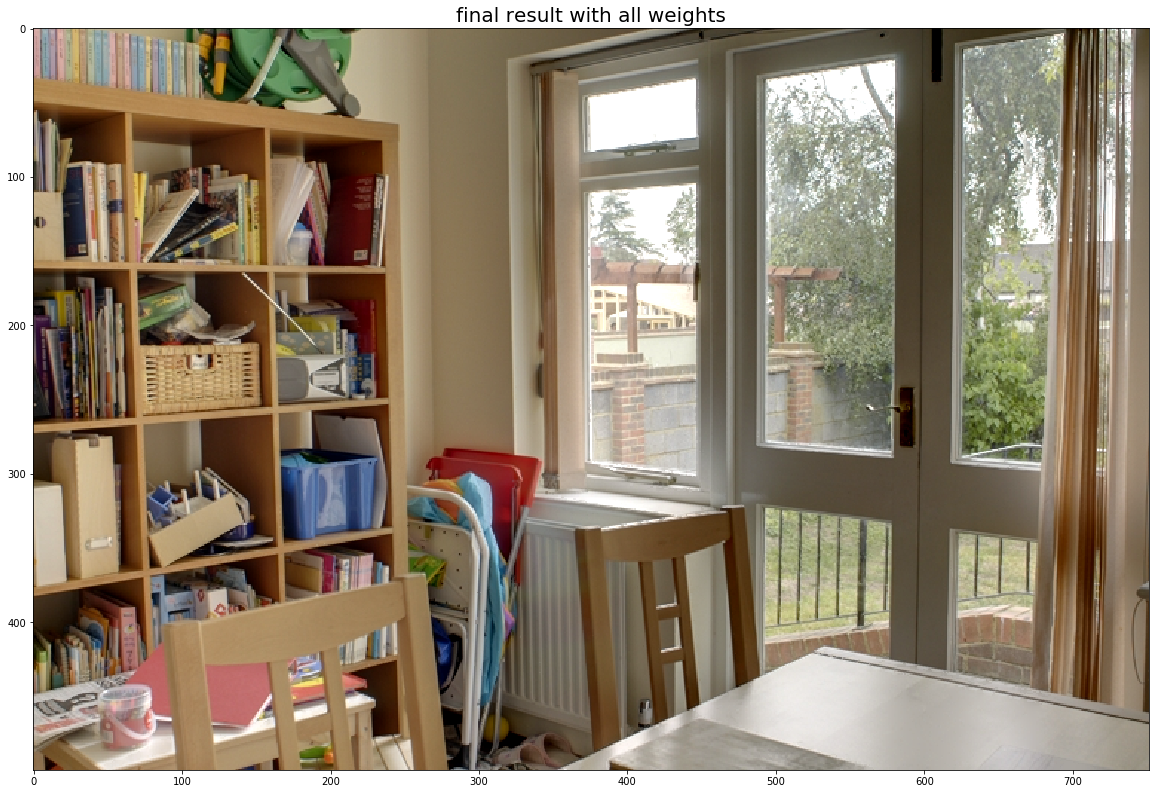

In [7]:
mergeMertens_all.showOriginalImages(figureSize=(20,20))
#(1,1,1)
mergeMertens_all.displayOutputImage(figureSize=(20,20),title="final result with all weights")